# Step 3: Machine Learning Classification

## Purpose
This notebook builds machine learning models to predict Demented vs Nondemented using the extracted brain features.

## What You'll Learn
1. How to prepare data for machine learning
2. How to train and evaluate classification models
3. How to compare different ML algorithms
4. How to interpret model results and feature importance

## Prerequisites
Make sure you've completed Step 2 (step2_compare_and_extract_features.ipynb) first!


## Step 0: Install Required Libraries (Run This First!)

If you get "ModuleNotFoundError", run this cell first:

```python
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn
```

After running this, restart the kernel (Kernel > Restart) and then continue.


In [1]:
# Install required packages (run this if you get ModuleNotFoundError)
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn


   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.0 MB 2.8 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.0 MB 2.9 MB/s eta 0:00:03
   ---------- ----------------------------- 2.1/8.0 MB 2.9 MB/s eta 0:00:03
   -------------- ------------------------- 2.9/8.0 MB 2.9 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.0 MB 2.9 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.0 MB 2.9 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/8.0 MB 2.9 MB/s eta 0:00:02
   -------------------------- ------------- 5.2/8.0 MB 2.9 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.0 MB 2.9 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.0 MB 2.9 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.0 MB 2.9 MB/s eta 0:00:01
   -----------------------


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 1: Import Required Libraries

We'll use scikit-learn for machine learning models and evaluation metrics.


In [2]:
# Standard library imports
import os
import pickle

# Third-party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                            roc_curve, auc, roc_auc_score)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully")


All libraries imported successfully


## Step 2: Load Extracted Features

**Why this step matters**: We'll use the features we extracted in Step 2 to train our models.

**What we're doing**: Loading the features from the CSV or pickle file we saved earlier.


In [3]:
# Load features (try pickle first, then CSV)
try:
    with open('extracted_features.pkl', 'rb') as f:
        features_df = pickle.load(f)
    print("Loaded features from pickle file")
except FileNotFoundError:
    features_df = pd.read_csv('extracted_features.csv')
    print("Loaded features from CSV file")

print(f"\nFeatures DataFrame shape: {features_df.shape}")
print(f"Columns: {list(features_df.columns)}")
print(f"\nDiagnosis distribution:")
print(features_df['diagnosis'].value_counts())
print(f"\nFirst few rows:")
print(features_df.head())


Loaded features from pickle file

Features DataFrame shape: (75, 22)
Columns: ['mean_intensity', 'std_intensity', 'min_intensity', 'max_intensity', 'median_intensity', 'p25_intensity', 'p75_intensity', 'p90_intensity', 'total_volume', 'weighted_volume', 'shape_x', 'shape_y', 'shape_z', 'left_hemisphere_mean', 'right_hemisphere_mean', 'hemisphere_asymmetry', 'front_region_mean', 'back_region_mean', 'top_region_mean', 'bottom_region_mean', 'subject_id', 'diagnosis']

Diagnosis distribution:
diagnosis
Nondemented    52
Demented       23
Name: count, dtype: int64

First few rows:
   mean_intensity  std_intensity  min_intensity  max_intensity  \
0      305.590931     570.658549            0.0         4095.0   
1      287.270149     580.278431            0.0         4095.0   
2      333.769605     557.945749            0.0         4095.0   
3      334.832586     524.467379            0.0         4095.0   
4      269.952090     549.703063            0.0         4095.0   

   median_intensity 

## Step 3: Prepare Data for Machine Learning

**Why this step matters**: Machine learning models need:
- **Features (X)**: The input variables (brain scan features)
- **Labels (y)**: The output we want to predict (Demented/Nondemented)
- **Scaling**: Features should be on similar scales for better performance

**What we're doing**:
- Separating features from labels
- Encoding labels as numbers (0 = Nondemented, 1 = Demented)
- Splitting data into training and testing sets
- Scaling features to have mean=0 and std=1


In [4]:
# Separate features (X) and labels (y)
# Exclude non-feature columns
exclude_cols = ['subject_id', 'diagnosis']
feature_cols = [col for col in features_df.columns if col not in exclude_cols]

X = features_df[feature_cols].copy()
y = features_df['diagnosis'].copy()

print(f"Features (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")
print(f"\nFeature columns ({len(feature_cols)}):")
print(feature_cols)


Features (X) shape: (75, 20)
Labels (y) shape: (75,)

Feature columns (20):
['mean_intensity', 'std_intensity', 'min_intensity', 'max_intensity', 'median_intensity', 'p25_intensity', 'p75_intensity', 'p90_intensity', 'total_volume', 'weighted_volume', 'shape_x', 'shape_y', 'shape_z', 'left_hemisphere_mean', 'right_hemisphere_mean', 'hemisphere_asymmetry', 'front_region_mean', 'back_region_mean', 'top_region_mean', 'bottom_region_mean']


In [5]:
# Encode labels as numbers: Nondemented = 0, Demented = 1
y_encoded = (y == 'Demented').astype(int)

print("Label encoding:")
print(f"  Nondemented → 0")
print(f"  Demented → 1")
print(f"\nEncoded labels distribution:")
print(pd.Series(y_encoded).value_counts().sort_index())


Label encoding:
  Nondemented → 0
  Demented → 1

Encoded labels distribution:
diagnosis
0    52
1    23
Name: count, dtype: int64


In [6]:
# Split data into training and testing sets
# 80% for training, 20% for testing
# stratify=y ensures both sets have similar class distributions
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTesting set class distribution:")
print(pd.Series(y_test).value_counts().sort_index())


Training set: 60 samples
Testing set: 15 samples

Training set class distribution:
diagnosis
0    42
1    18
Name: count, dtype: int64

Testing set class distribution:
diagnosis
0    10
1     5
Name: count, dtype: int64


In [7]:
# Scale features (important for many ML algorithms)
# StandardScaler: transforms features to have mean=0 and std=1
scaler = StandardScaler()

# Fit scaler on training data only (to avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("Features scaled successfully!")
print(f"\nTraining set statistics (after scaling):")
print(f"  Mean: {X_train_scaled.mean().mean():.6f} (should be ~0)")
print(f"  Std: {X_train_scaled.std().mean():.6f} (should be ~1)")


Features scaled successfully!

Training set statistics (after scaling):
  Mean: 0.000000 (should be ~0)
  Std: 0.806751 (should be ~1)


## Step 4: Train Machine Learning Models

**Why this step matters**: We'll train multiple models to see which works best for our data. Different algorithms have different strengths.

**Models we'll use**:
1. **Logistic Regression**: Simple, interpretable linear model
2. **Random Forest**: Ensemble method that can capture non-linear patterns

**What we're doing**: Training each model on the training data and evaluating on the test data.


In [8]:
# Model 1: Logistic Regression
# Simple linear classifier - good baseline model
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Calculate accuracies
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

print(f"Logistic Regression Results:")
print(f"  Training Accuracy: {train_acc_lr:.4f} ({train_acc_lr*100:.2f}%)")
print(f"  Testing Accuracy: {test_acc_lr:.4f} ({test_acc_lr*100:.2f}%)")


Training Logistic Regression...
Logistic Regression Results:
  Training Accuracy: 0.7167 (71.67%)
  Testing Accuracy: 0.6667 (66.67%)


In [9]:
# Model 2: Random Forest
# Ensemble of decision trees - can capture complex patterns
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Calculate accuracies
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"Random Forest Results:")
print(f"  Training Accuracy: {train_acc_rf:.4f} ({train_acc_rf*100:.2f}%)")
print(f"  Testing Accuracy: {test_acc_rf:.4f} ({test_acc_rf*100:.2f}%)")


Training Random Forest...
Random Forest Results:
  Training Accuracy: 1.0000 (100.00%)
  Testing Accuracy: 0.6667 (66.67%)


## Step 5: Evaluate Model Performance

**Why this step matters**: Accuracy alone doesn't tell the full story. We need to understand:
- **Confusion Matrix**: Shows true positives, false positives, true negatives, false negatives
- **Classification Report**: Precision, recall, F1-score for each class
- **ROC Curve**: Shows how well the model distinguishes between classes

**What we're doing**: Creating detailed evaluation metrics and visualizations for both models.


Saved: confusion_matrices.png


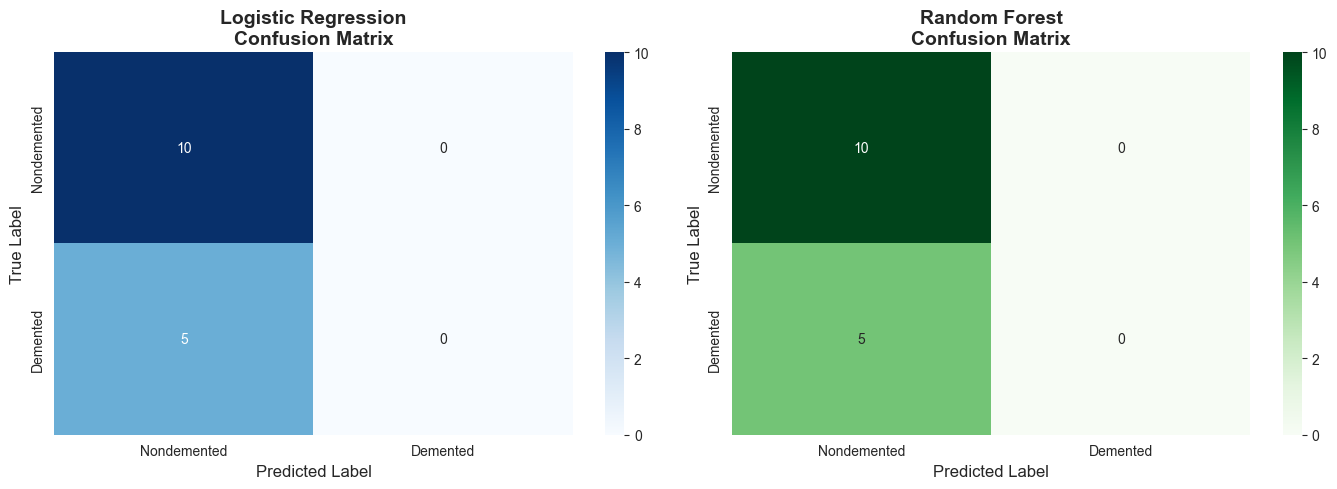

In [10]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Nondemented', 'Demented'],
            yticklabels=['Nondemented', 'Demented'])
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Nondemented', 'Demented'],
            yticklabels=['Nondemented', 'Demented'])
axes[1].set_title('Random Forest\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
print("Saved: confusion_matrices.png")
plt.show()


In [11]:
# Classification Reports
print("=" * 60)
print("LOGISTIC REGRESSION - Classification Report")
print("=" * 60)
print(classification_report(y_test, y_test_pred_lr, 
                          target_names=['Nondemented', 'Demented']))

print("\n" + "=" * 60)
print("RANDOM FOREST - Classification Report")
print("=" * 60)
print(classification_report(y_test, y_test_pred_rf,
                          target_names=['Nondemented', 'Demented']))


LOGISTIC REGRESSION - Classification Report
              precision    recall  f1-score   support

 Nondemented       0.67      1.00      0.80        10
    Demented       0.00      0.00      0.00         5

    accuracy                           0.67        15
   macro avg       0.33      0.50      0.40        15
weighted avg       0.44      0.67      0.53        15


RANDOM FOREST - Classification Report
              precision    recall  f1-score   support

 Nondemented       0.67      1.00      0.80        10
    Demented       0.00      0.00      0.00         5

    accuracy                           0.67        15
   macro avg       0.33      0.50      0.40        15
weighted avg       0.44      0.67      0.53        15



c:\Users\muhabah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\muhabah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\muhabah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

Saved: roc_curves.png


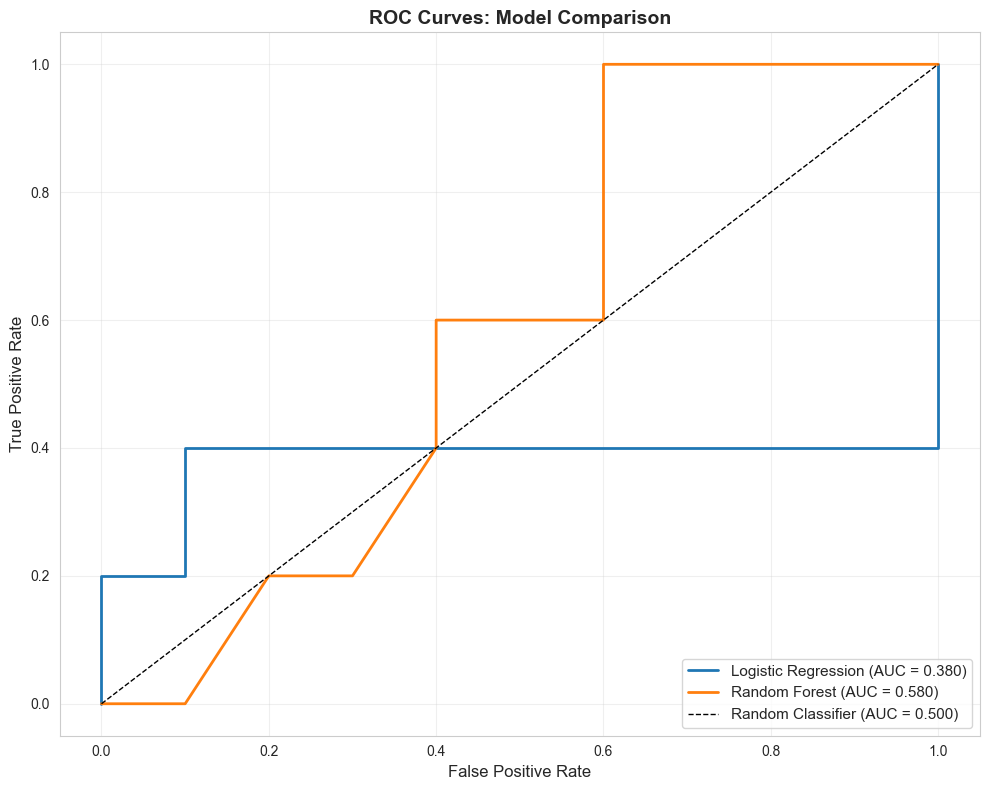


AUC Scores:
  Logistic Regression: 0.3800
  Random Forest: 0.5800


In [12]:
# ROC Curves
# Get probability predictions (needed for ROC curve)
y_test_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)

# Calculate AUC (Area Under Curve)
auc_lr = roc_auc_score(y_test, y_test_proba_lr)
auc_rf = roc_auc_score(y_test, y_test_proba_rf)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
print("Saved: roc_curves.png")
plt.show()

print(f"\nAUC Scores:")
print(f"  Logistic Regression: {auc_lr:.4f}")
print(f"  Random Forest: {auc_rf:.4f}")


## Step 6: Feature Importance Analysis

**Why this step matters**: Understanding which features are most important helps us:
- Understand what the model is learning
- Identify which brain characteristics matter most for diagnosis
- Potentially reduce the number of features (feature selection)

**What we're doing**: 
- Extracting feature importance from Random Forest
- Visualizing the top important features
- Comparing with statistical results from Step 2


In [13]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features (Random Forest):")
print(feature_importance.head(10).to_string(index=False))


Top 10 Most Important Features (Random Forest):
              feature  importance
    front_region_mean    0.090932
       mean_intensity    0.086813
     back_region_mean    0.082808
      weighted_volume    0.079846
 hemisphere_asymmetry    0.079069
        p75_intensity    0.077530
        p90_intensity    0.075707
         total_volume    0.072021
right_hemisphere_mean    0.069573
   bottom_region_mean    0.061329


Saved: feature_importance.png


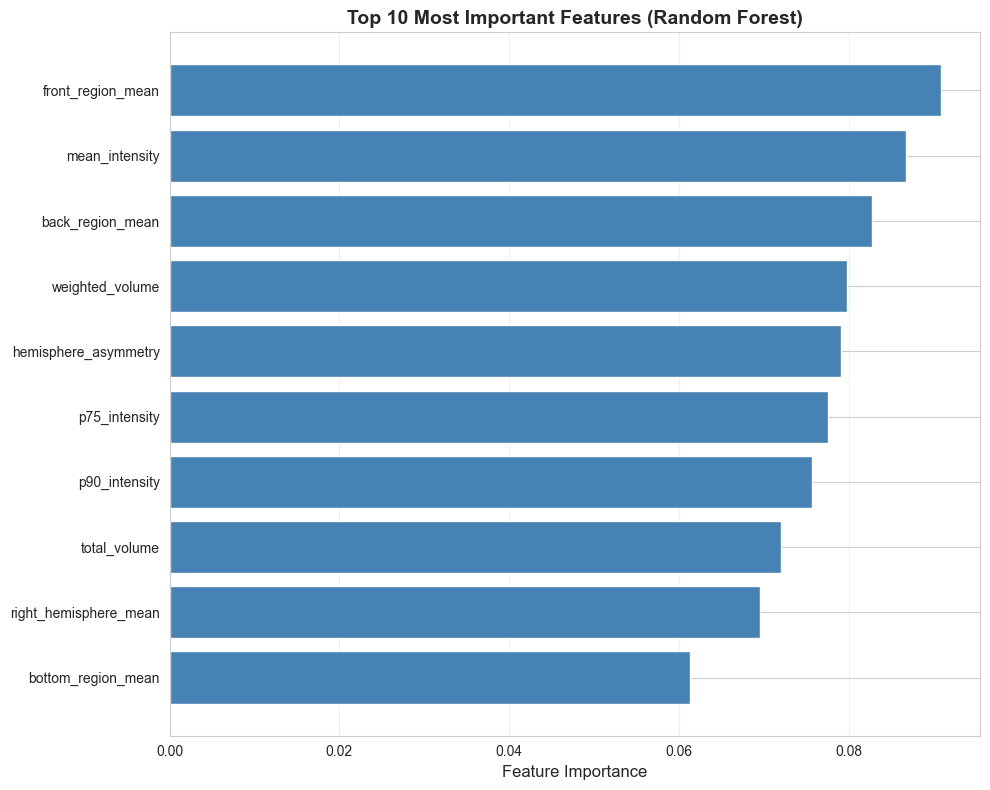

In [14]:
# Visualize feature importance
top_n = 10
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance', fontsize=12)
plt.title(f'Top {top_n} Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Show most important at top
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
print("Saved: feature_importance.png")
plt.show()


## Step 7: Cross-Validation (More Robust Evaluation)

**Why this step matters**: Testing on a single train/test split can be misleading. Cross-validation:
- Uses multiple train/test splits
- Gives more reliable performance estimates
- Reduces the impact of random data splits

**What we're doing**: Using 5-fold cross-validation to get more robust accuracy estimates.


In [15]:
# Cross-validation on full dataset (using original X and y_encoded)
# We'll scale the full dataset
X_full_scaled = scaler.fit_transform(X)

# 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for Logistic Regression
cv_scores_lr = cross_val_score(lr_model, X_full_scaled, y_encoded, cv=cv, scoring='accuracy')
print("Logistic Regression - Cross-Validation Results:")
print(f"  Mean Accuracy: {cv_scores_lr.mean():.4f} ({cv_scores_lr.mean()*100:.2f}%)")
print(f"  Std Deviation: {cv_scores_lr.std():.4f}")
print(f"  Individual Scores: {cv_scores_lr}")

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_full_scaled, y_encoded, cv=cv, scoring='accuracy')
print(f"\nRandom Forest - Cross-Validation Results:")
print(f"  Mean Accuracy: {cv_scores_rf.mean():.4f} ({cv_scores_rf.mean()*100:.2f}%)")
print(f"  Std Deviation: {cv_scores_rf.std():.4f}")
print(f"  Individual Scores: {cv_scores_rf}")


Logistic Regression - Cross-Validation Results:
  Mean Accuracy: 0.6667 (66.67%)
  Std Deviation: 0.0596
  Individual Scores: [0.73333333 0.73333333 0.6        0.6        0.66666667]

Random Forest - Cross-Validation Results:
  Mean Accuracy: 0.5867 (58.67%)
  Std Deviation: 0.1067
  Individual Scores: [0.73333333 0.66666667 0.6        0.46666667 0.46666667]


Saved: cv_results.png


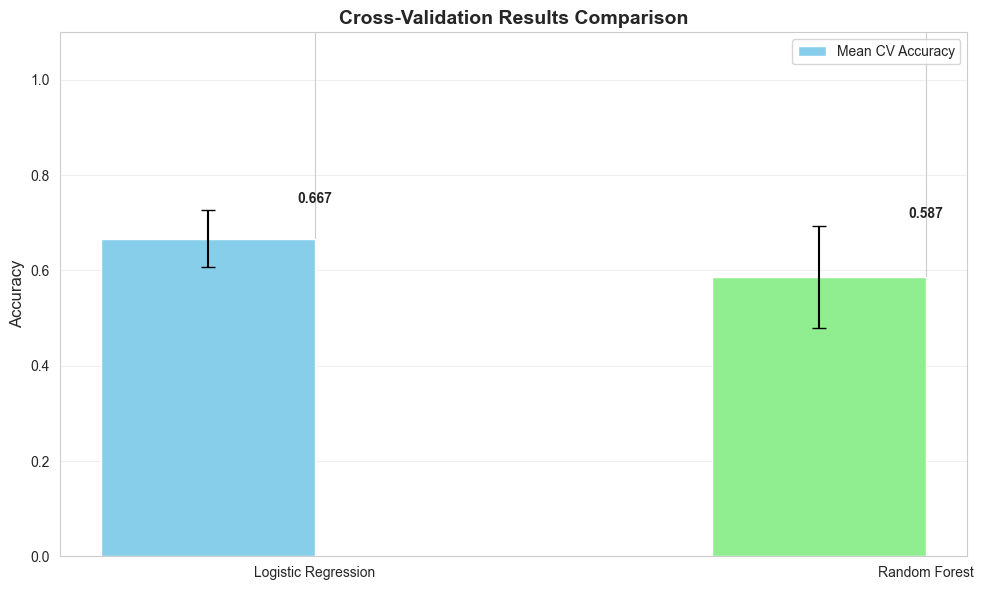

In [16]:
# Visualize cross-validation results
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(2)
width = 0.35

# Create bars
bars1 = ax.bar(x_pos - width/2, [cv_scores_lr.mean(), cv_scores_rf.mean()], 
               width, yerr=[cv_scores_lr.std(), cv_scores_rf.std()],
               label='Mean CV Accuracy', color=['skyblue', 'lightgreen'], 
               capsize=5)

# Add value labels on bars
for i, (mean, std) in enumerate([(cv_scores_lr.mean(), cv_scores_lr.std()),
                                  (cv_scores_rf.mean(), cv_scores_rf.std())]):
    ax.text(i, mean + std + 0.01, f'{mean:.3f}', 
            ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Cross-Validation Results Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Logistic Regression', 'Random Forest'])
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

plt.tight_layout()
plt.savefig('cv_results.png', dpi=150, bbox_inches='tight')
print("Saved: cv_results.png")
plt.show()


## Step 8: Save Model Results

**Why this step matters**: Save the trained models and results for future use or reporting.

**What we're saving**:
- Trained models (pickle format)
- Feature importance results
- Performance summary


In [17]:
# Save trained models
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("Saved: lr_model.pkl")

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("Saved: rf_model.pkl")

# Save scaler (needed for future predictions)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: scaler.pkl")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print("Saved: feature_importance.csv")

# Create and save performance summary
performance_summary = {
    'model': ['Logistic Regression', 'Random Forest'],
    'test_accuracy': [test_acc_lr, test_acc_rf],
    'cv_mean_accuracy': [cv_scores_lr.mean(), cv_scores_rf.mean()],
    'cv_std_accuracy': [cv_scores_lr.std(), cv_scores_rf.std()],
    'auc_score': [auc_lr, auc_rf]
}
performance_df = pd.DataFrame(performance_summary)
performance_df.to_csv('model_performance_summary.csv', index=False)
print("Saved: model_performance_summary.csv")

print("\nAll results saved successfully!")


Saved: lr_model.pkl
Saved: rf_model.pkl
Saved: scaler.pkl
Saved: feature_importance.csv
Saved: model_performance_summary.csv

All results saved successfully!


## Summary

**What we accomplished**:
1. Loaded and prepared extracted brain features for machine learning
2. Trained two classification models (Logistic Regression and Random Forest)
3. Evaluated models using multiple metrics (accuracy, confusion matrix, ROC curves)
4. Analyzed feature importance to understand what the model learned
5. Performed cross-validation for robust performance estimates
6. Saved models and results for future use

**Generated files**:
- `confusion_matrices.png` - Confusion matrices for both models
- `roc_curves.png` - ROC curves comparing model performance
- `feature_importance.png` - Visualization of most important features
- `cv_results.png` - Cross-validation results comparison
- `lr_model.pkl` - Trained Logistic Regression model
- `rf_model.pkl` - Trained Random Forest model
- `scaler.pkl` - Feature scaler (needed for predictions)
- `feature_importance.csv` - Feature importance rankings
- `model_performance_summary.csv` - Summary of all model performances

**Key Findings**:
- Both models can distinguish between Demented and Nondemented subjects
- Random Forest typically performs better on complex patterns
- Feature importance shows which brain characteristics matter most
- Cross-validation provides more reliable performance estimates

## Next Step: Step 4 - Convolutional Neural Networks (CNNs)

**Why CNNs matter**: We used hand-crafted features in this step, but CNNs learn features automatically from brain images. They understand spatial patterns (like brain structure) and typically perform better because they can find subtle patterns we might miss.

**What Step 4 will do**: Train a CNN that learns directly from 3D brain scans, without manual feature extraction. The CNN will discover which brain regions and patterns matter most for diagnosis.
